# GNSS Review

## Initialise Python environment

In [89]:
# Standard modules import first 
import pandas as pd
import numpy as np
import pymap3d as pm
import matplotlib.pyplot as plt

# Add personnal module after (error otherwise)
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader

from plots import plotLineTimeRange, plotHist, plotEN_pyplot, plot_hist_pyplot

## Prepare log data

This function define a dictionnary containing all the required data about the log.

In [90]:
def getLogDictionnary(device_name, filepath, time_range, color):
    return {
        'device_name' : device_name,
        'filepath'    : filepath,
        'time_range'  : time_range,
        'color'       : color
    }

We add the logs in a common to compare them all together.

In [91]:
logs = []

logs.append(getLogDictionnary(
    "Google Pixel 7",
    "../.data/static/gnss_log_GooglePixel7_2023_02_17_09_55_01.txt",
    (None, None),
    "tab:blue"
))

logs.append(getLogDictionnary(
    "OnePlus Nord 2",
    "../.data/static/gnss_log_OnePlusNord2_2023_03_03_10_55_04.txt",
    (None, None),
    "tab:orange"
))

logs.append(getLogDictionnary(
    "Samsung A52",
    "../.data/static/gnss_log_SamsungA52_2023_03_17_14_12_30.txt",
    (None, None),
    "tab:green"
))

logs.append(getLogDictionnary(
    "Xiaomi 11T",
    "../.data/static/gnss_log_Xiaomi11T_2023_03_03_09_56_06.txt",
    (None, None),
    "tab:red"
))

ref_enu = [61.449219, 23.856267, 166.0]

All the log are parsed and transformed into panda dataframes.

In [92]:
for log in logs:
    log['content'] = LogReader(log['filepath'], ['Raw', 'Fix'])

# Position analysis

We define conversion function from geodetic to ENU.

In [93]:
def convert2ENU(lat, lon, alt, ref):
    east, north, up = pm.geodetic2enu(lat, lon, alt, ref[0], ref[1], ref[2])
    return {"east":east, "north":north, "up":up}

def getHorizontalError(north, east):
    error = np.sqrt(north**2 + east**2)
    return {"2D_error":error}

In [99]:
def plotENU(ts : pd.DataFrame, axs, logDict):
    ts['north'].plot(ax=axs[0], label=logDict['device_name'])
    ts['east'].plot(ax=axs[1], label=logDict['device_name'])
    ts['up'].plot(ax=axs[2], label=logDict['device_name'])

def plotEN(ts : pd.DataFrame, axs, logDict, lim):
    ts.plot(x='east', y='north', kind='scatter', label=logDict['device_name'], color=logDict['color'], s=6, zorder=3, ax=axs)
    plt.axis('square')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel('East [m]')
    plt.ylabel('North [m]')
    plt.grid(zorder=0)
    

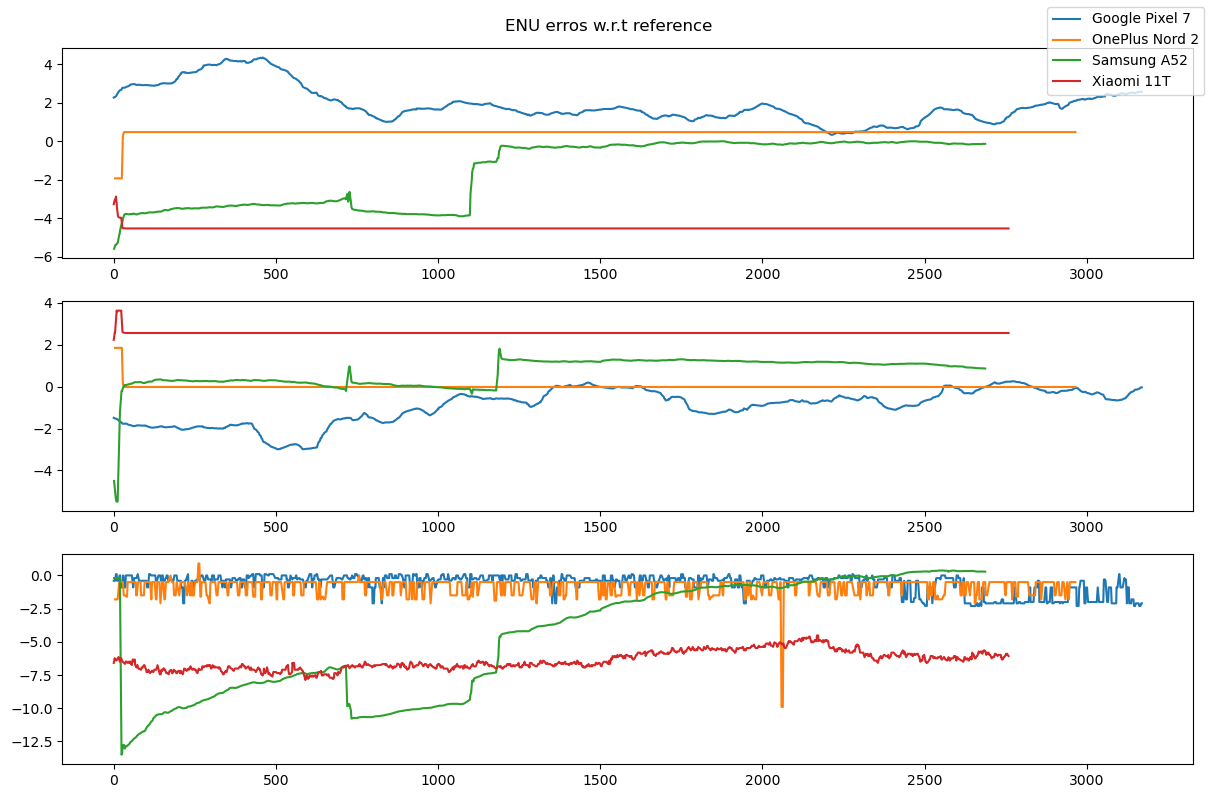

In [103]:
fig, axs = plt.subplots(3, figsize=(12,8))
fig.suptitle('ENU erros w.r.t reference')
for log in logs:
    pos = log['content'].fix.loc[log['content'].fix['provider'].isin(['GPS']), ['datetime', 'latitude', 'longitude', 'altitude']]
    
    # Transform to time serie
    #pos = pos.set_index('datetime')

    # Filter by time
    #pos = pos.loc[time_range[0]:time_range[1]]

    pos[["east", "north", "up"]] = pos.apply(
        lambda row: convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log['content'].fix

    #plotEN_pyplot(pos, 5)
    plotENU(pos, axs, log)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.tight_layout()


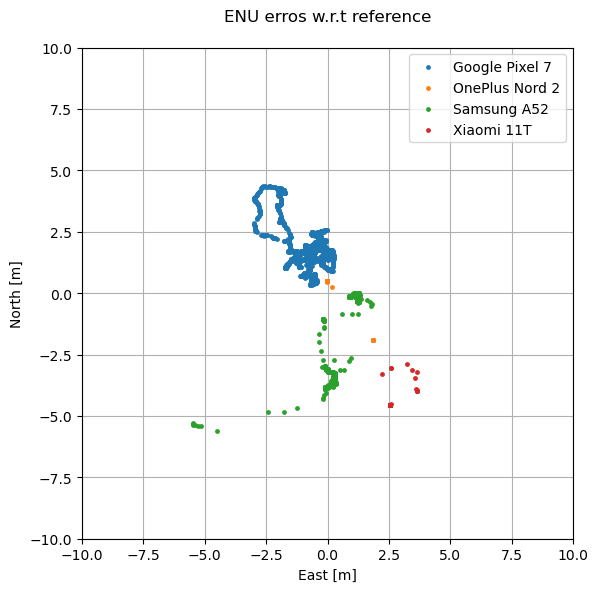

In [102]:
fig, axs = plt.subplots(1, figsize=(9,6))
fig.suptitle('ENU erros w.r.t reference')
for log in logs:
    pos = log['content'].fix.loc[log['content'].fix['provider'].isin(['FLP']), ['datetime', 'latitude', 'longitude', 'altitude']]
    
    # Transform to time serie
    #pos = pos.set_index('datetime')

    # Filter by time
    #pos = pos.loc[time_range[0]:time_range[1]]

    pos[["east", "north", "up"]] = pos.apply(
        lambda row: convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log['content'].fix

    #plotEN_pyplot(pos, 5)
    plotEN(pos, axs, log, 10)

handles, labels = axs.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')
fig.tight_layout()

## Pseudorange Analysis

In [50]:
# Turn to time serie
ts = log.raw.set_index('datetime')

data_name = 'PseudorangeAcceleration'

sats = list(set(ts["prn"]))
sats.sort()
sats = [item for item in sats if item.startswith('G')]
sats = ['G02-L1']

_ts = ts.loc[ts['prn'].isin(sats), [data_name, 'prn']]

# Filter
# _ts[data_name] = _ts[data_name].abs()
# q = _ts[data_name].quantile(0.99)
# _ts = _ts[ts[data_name] < q] 

p = plotHist(_ts, data_name)
show(p)
#save(p, filename="pseudo_error_Galileo.html")
#export_png(p, filename="pseudo_error_Galileo.png")

plot_hist_pyplot(_ts, data_name, lim=50)
plt.title(f'Pseudoranges error for {deviceName}')
plt.margins(x=0)
plt.xlim(0,50)
plt.show()


AttributeError: 'dict' object has no attribute 'raw'

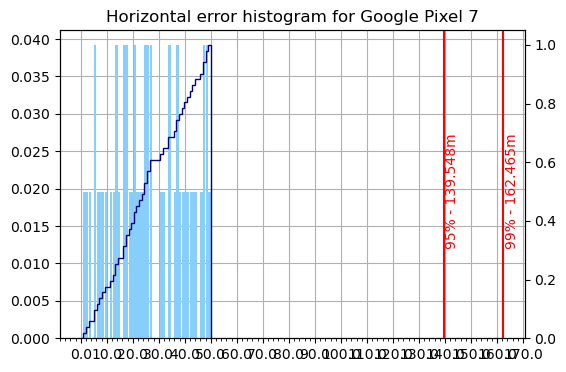

In [ ]:
#plot_hist_pyplot(pos, 'east', lim=np.max(np.abs(ts[data_name])))

pos[["2D_error"]] = pos.apply(
    lambda row: getHorizontalError(row['north'], row['east']), 
    axis='columns', result_type='expand')

plot_hist_pyplot(pos, '2D_error', lim=50)
plt.title(f'Horizontal error histogram for {deviceName}')
plt.show()